In [ ]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as pyplot
import tensorflow as tf


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!mv /content/gdrive/MyDrive/colabdata/aiffel/human_segmentation/images/young.jpg /content/data

mv: cannot stat '/content/gdrive/MyDrive/colabdata/aiffel/human_segmentation/images/young.jpg': No such file or directory


In [ ]:
!ls /content/gdrive/MyDrive/colabdata/aiffel/human_segmentation/images

cat.jpg  IMG_0856.JPG  IMG_0858.JPG  pr1.png  pr2.png  pr3.png	ski.PNG


In [ ]:
import os
img_path = '/content/data/young.jpg'
img_orig = cv2.imread(img_path)

In [ ]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'


    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

   
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)


        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [ ]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/data/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)
with tf.device('/device:GPU:0'):
  MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/data/human_segmentation/models
model loaded successfully!


In [ ]:
img_resized, seg_map_orig = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(457, 340, 3) (513, 381, 3) 15


In [ ]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

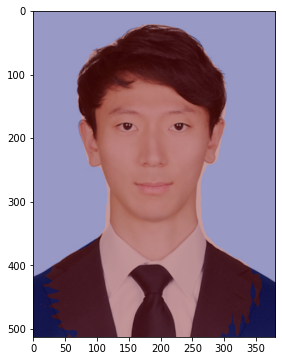

In [ ]:
img_show = img_resized.copy()
seg_map = np.where(seg_map_orig == 15, 15, 0) 
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

pyplot.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.rcParams["figure.figsize"]=(6,6)
pyplot.show()

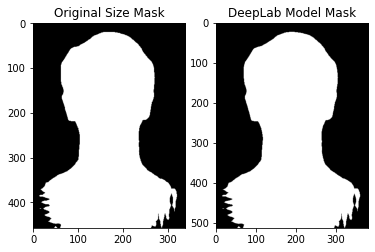

In [ ]:
import matplotlib.pyplot as plt
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

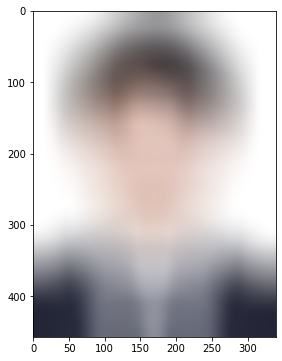

In [ ]:
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_orig_blur = cv2.blur(img_orig, (100,100))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()


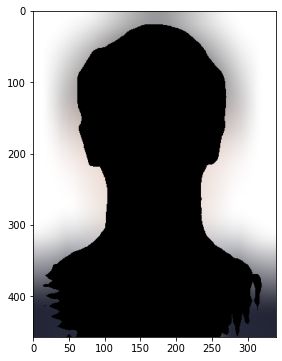

'\nimg_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)\nimg_bg_mask = cv2.bitwise_not(img_mask_color)\nimg_bg_mask = cv2.bitwise_and(img_orig, img_bg_mask)\nimg_bg_blur = cv2.blur(img_bg_mask, (100,100),)\nplt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))\nplt.show()\n'

In [ ]:

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()
'''
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_mask = cv2.bitwise_and(img_orig, img_bg_mask)
img_bg_blur = cv2.blur(img_bg_mask, (100,100),)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()
'''

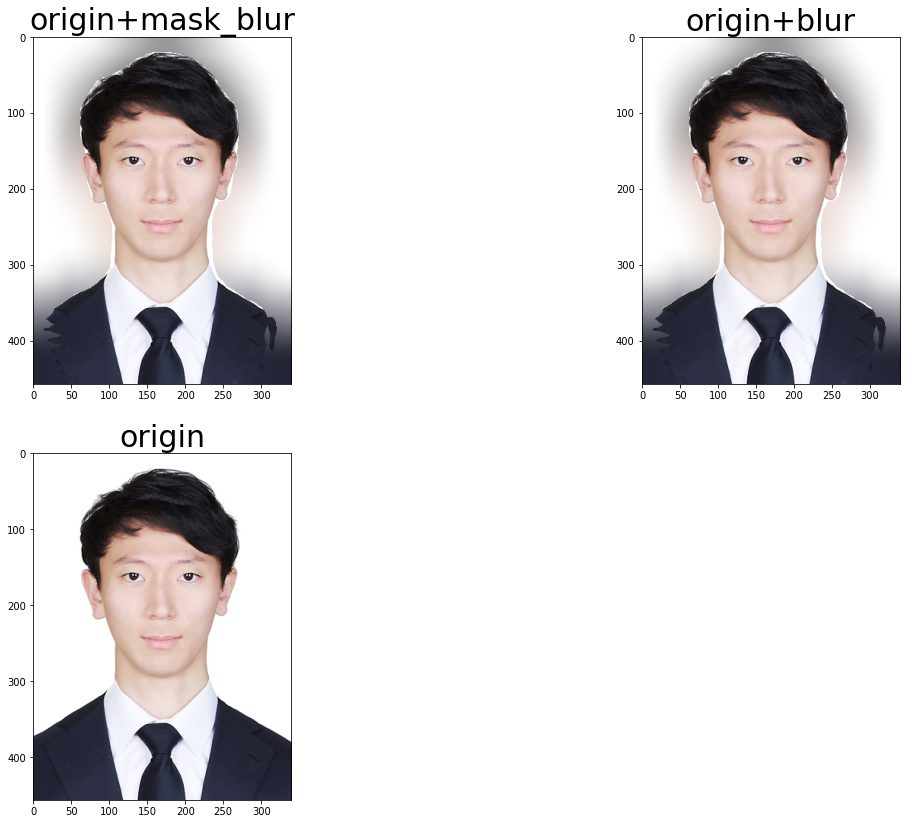

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_orig_blur)

fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.subplots_adjust(bottom=0.35)

ax = plt.subplot(2,2,1)
ax.set_title('origin+mask_blur',fontsize=30)
ax.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(2,2,3)
ax.set_title('origin',fontsize=30)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
ax = plt.subplot(2,2,2)
ax.set_title('origin+blur',fontsize=30,)
ax.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(2,2,4)
fig.delaxes(ax)



fig.show()

In [ ]:
!mv 

mv: missing file operand
Try 'mv --help' for more information.


In [ ]:
#img_path = '/content/data/'
img_path = '/content/gdrive/MyDrive/colabdata/aiffel/human_segmentation/images/'
img_orig = [cv2.imread(img_path+'cat.jpg'),cv2.imread(img_path+'ski.PNG'),cv2.imread(img_path+'IMG_0856.JPG'),cv2.imread(img_path+'IMG_0858.JPG')]

In [ ]:
img_resized, seg_map = MODEL.run(img_orig[0])

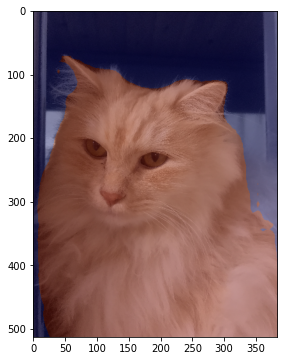

In [ ]:

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) 
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

pyplot.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
pyplot.show()

In [ ]:
img_mask_up = cv2.resize(img_mask, img_orig[0].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

<function matplotlib.pyplot.show>

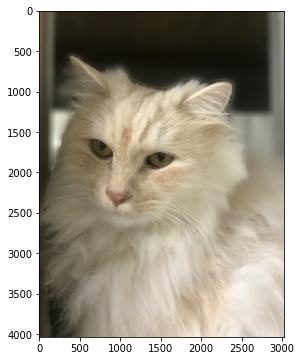

In [ ]:
img_orig_blur = cv2.blur(img_orig[0], (100,100))
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_concat = np.where(img_mask_color==255, img_orig[0], img_orig_blur)
plt.imshow(cv2.cvtColor(img_concat,cv2.COLOR_BGR2RGB))
plt.show

In [ ]:
img_resized , seg_map= MODEL.run(img_orig[1])
seg_map=np.where(seg_map==15, 15, 0)
img_mask = seg_map*(255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
img_mask_up = cv2.resize(img_mask,img_orig[1].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128,255,cv2.THRESH_BINARY)

<function matplotlib.pyplot.show>

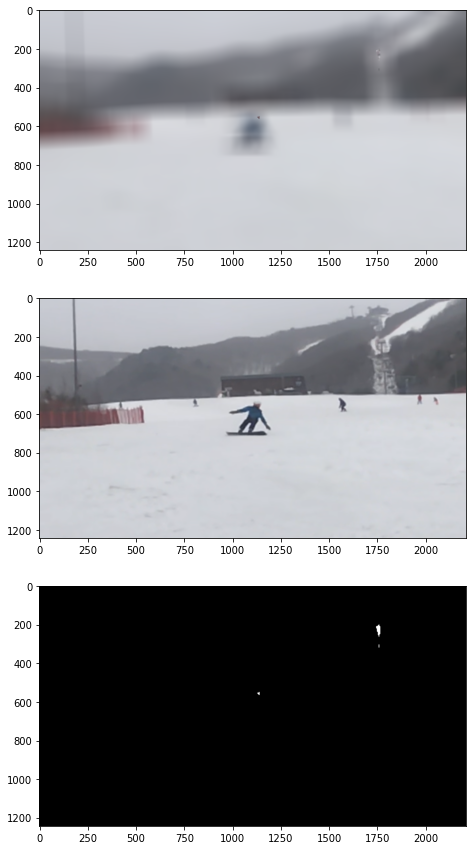

In [ ]:
img_orig_blur = cv2.blur(img_orig[1],(100,100))
img_mask_color= cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_concat=np.where(img_mask_color==255,img_orig[1],img_orig_blur)
f, axs = plt.subplots(3,1,figsize=(15,15))
plt.subplot(3,1,1)
plt.imshow(cv2.cvtColor(img_concat,cv2.COLOR_BGR2RGB))
plt.subplot(3,1,2)
plt.imshow(cv2.cvtColor(img_orig[1],cv2.COLOR_BGR2RGB))
plt.subplot(3,1,3)
plt.imshow(cv2.cvtColor(img_mask_up,cv2.COLOR_GRAY2RGB))
plt.show

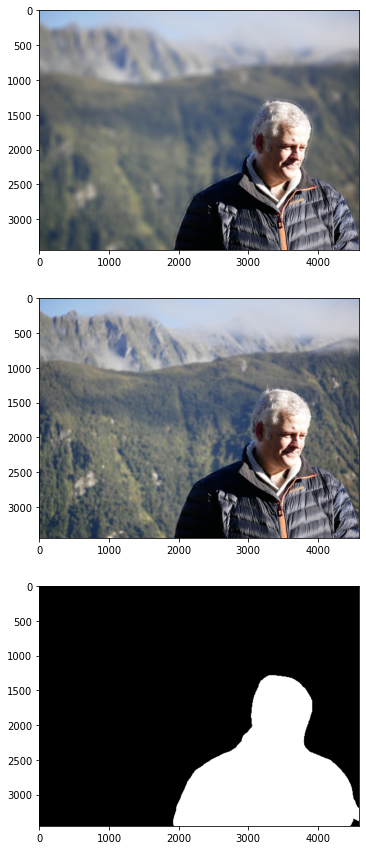

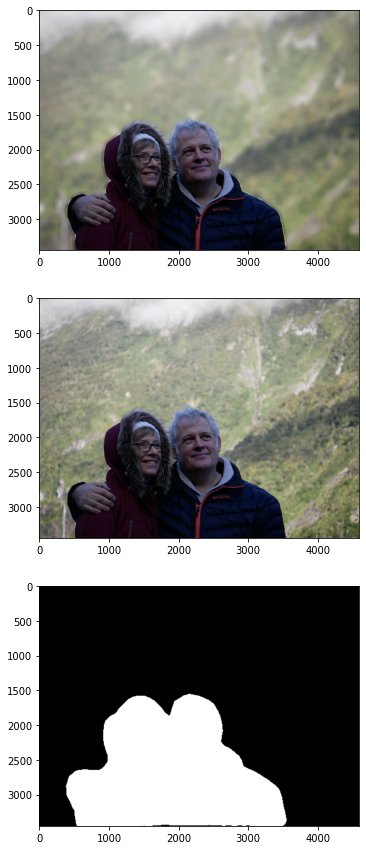

In [ ]:
for i in range(2,4):
  img_resized , seg_map= MODEL.run(img_orig[i])
  seg_map=np.where(seg_map==15, 15, 0)
  img_mask = seg_map*(255/seg_map.max())
  img_mask = img_mask.astype(np.uint8)
  img_mask_up = cv2.resize(img_mask,img_orig[i].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
  _, img_mask_up = cv2.threshold(img_mask_up, 128,255,cv2.THRESH_BINARY)
  img_orig_blur = cv2.blur(img_orig[i],(100,100))
  img_mask_color= cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
  img_concat=np.where(img_mask_color==255,img_orig[i],img_orig_blur)
  f, axs = plt.subplots(3,1,figsize=(15,15))
  plt.subplot(3,1,1)
  plt.imshow(cv2.cvtColor(img_concat,cv2.COLOR_BGR2RGB))
  plt.subplot(3,1,2)
  plt.imshow(cv2.cvtColor(img_orig[i],cv2.COLOR_BGR2RGB))
  plt.subplot(3,1,3)
  plt.imshow(cv2.cvtColor(img_mask_up,cv2.COLOR_GRAY2RGB))
  plt.show

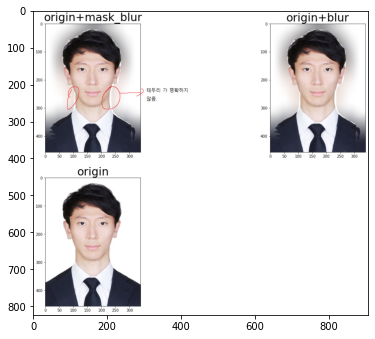

In [ ]:
img_path = '/content/gdrive/MyDrive/colabdata/aiffel/human_segmentation/images/'
img_name = [img_path+'pr1.png',img_path+'pr2.png',img_path+'pr3.png']
plt.imshow(cv2.cvtColor(cv2.imread(img_name[0]),cv2.COLOR_BGR2RGB))
plt.rcParams["figure.figsize"]=(20,20)
plt.show()

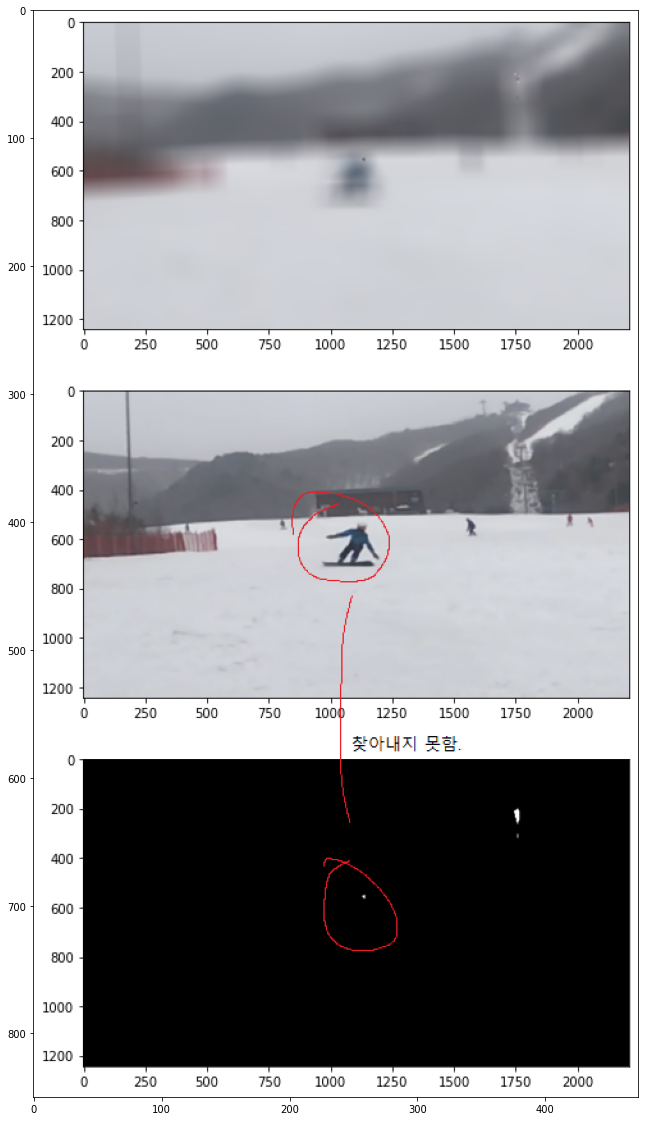

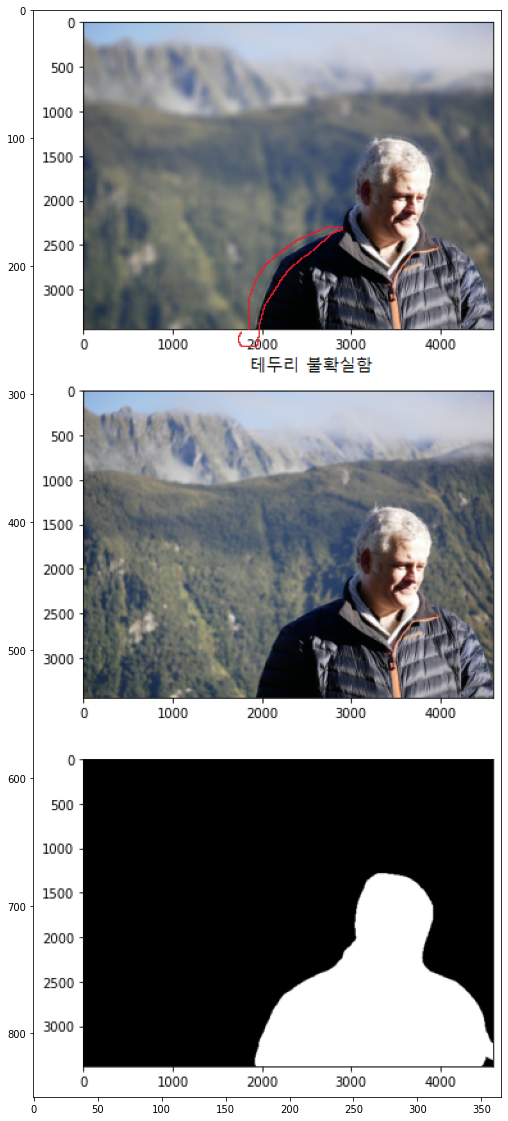

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(img_name[1]),cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(cv2.imread(img_name[2]),cv2.COLOR_BGR2RGB))
plt.show()

depth 에 대한 정보가 있다면,마스크 내부의 depth 값의 평균에 가까운 값으로 depth를 이용한 마스크를 재생성 후 적용. depth의 해상도가 높다면 해당 물체의 이미지와 주변 이미지를 더 깔끔하게 분리가능. 

[삼성 뉴스룸](https://news.samsung.com/kr/%EA%B0%A4%EB%9F%AD%EC%8B%9C-s21-ai-%EC%B9%B4%EB%A9%94%EB%9D%BC-%E2%91%A0-ai%EA%B0%80-%EC%9D%B8%EB%AC%BC%EC%82%AC%EC%A7%84%EC%9D%84-%ED%98%81%EC%8B%A0%EC%A0%81%EC%9C%BC%EB%A1%9C-%EA%B0%9C%EC%84%A0)
해당 링크에서 설명하는 바와 같이 매트맵을 구현한다면 위의 문제를 제거 가능


블러는 배경에 대해서만 블러가 되어야하는데 cv2.blur는 해당 이미지 내부를 모두 블러처리함 (마스크후 블러 역시 마스크를 검은색으로 하여 블러처리) 하여 블러를 재작성하여 마스크 부분을 제외하고 블러할 수 있도록 해야함.

이미지를 작게 리사이징 후 구분을 하기 때문에 작은 사이즈는 구분이 힘듬.
스트라이드 값을 조절하여 크랍한 후 나온 이미지로 마스킹처리하기.
 이 경우 사이즈 조절로 원하는 거리감에 있는 사람을 가져오기 쉽지 않음.